In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
from langchain_ollama.chat_models import ChatOllama

llm = ChatOllama(model="gpt-oss:120b-cloud", temperature=0.0)

In [3]:
from supabase.client import Client, create_client

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

E0000 00:00:1760594629.741110 9093663 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1760594629.743858 9093663 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [5]:
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_community.vectorstores import SupabaseVectorStore

vector_store = SupabaseVectorStore(
    embedding=embeddings,
    client=supabase,
    table_name="documents_temp",
    query_name="match_documents_temp",
)

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [7]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

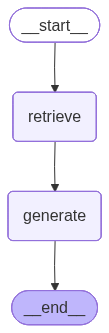

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
result = graph.invoke({"question": "what is the business and application environment of the TPCH-H database?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

I0000 00:00:1760594635.832986 9093663 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Context: [Document(metadata={'page': 10, 'title': '0: INTRODUCTION', 'author': 'John Galloway', 'source': '../../data/TPC-H_v3.0.1.pdf', 'creator': 'Microsoft® Word for Microsoft 365', 'moddate': '2022-04-28T16:01:40-07:00', 'producer': 'Microsoft® Word for Microsoft 365', 'page_label': '11', 'total_pages': 138, 'creationdate': '2022-04-28T16:01:40-07:00'}, page_content="TPC BenchmarkTM H Standard Specification Revision 3.0.1 Page 11 \n1:  LOGICAL DATABASE DESIGN \n1.1 Business and Application Environment \nTPC Benchmark™ H is comprised of a set of business queries designed to exercise system functionalities in a \nmanner representative of complex business analysis applications. T hese queries have been given a realistic context, \nportraying the activity of a wholesale supplier to help the reader relate intuitively to the components of the \nbenchmark. \n \nTPC-H does not represent the activity of any particular business segment, but rathe r any industry which must \nmanage sell, or d

# Agentic RAG

In [10]:
from langchain.tools.retriever import create_retriever_tool

retriever = vector_store.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_docs",
    "Search and return information about TPC-H database.",
)

In [11]:
doc = retriever_tool.invoke({"query": "what is the business and application environment of the TPCH-H database?"})
print(doc)

TPC BenchmarkTM H Standard Specification Revision 3.0.1 Page 11 
1:  LOGICAL DATABASE DESIGN 
1.1 Business and Application Environment 
TPC Benchmark™ H is comprised of a set of business queries designed to exercise system functionalities in a 
manner representative of complex business analysis applications. T hese queries have been given a realistic context, 
portraying the activity of a wholesale supplier to help the reader relate intuitively to the components of the 
benchmark. 
 
TPC-H does not represent the activity of any particular business segment, but rathe r any industry which must 
manage sell, or distribute a product worldwide (e.g., car rental, food distribution, parts, suppliers, etc.). TPC -H does 
not attempt to be a model of how to build an actual information analysis application.  
 
The purpose of this be nchmark is to reduce the diversity of operations found in an information analysis application, 
while retaining the application's essential performance characterist

In [14]:
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq

# response_model = ChatOllama(model="gpt-oss:120b-cloud", temperature=0.0)
response_model = ChatGroq(model="openai/gpt-oss-120b", temperature=0.0)

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    llm = response_model.bind_tools([retriever_tool])
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


In [15]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


In [16]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What is the business and application environment of the TPCH-H database?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

**TPC‑H (Transaction Processing Performance Council – H) – Business & Application Context**

| Aspect | Description |
|--------|-------------|
| **Primary Business Goal** | Provide a **standardized decision‑support (DS) benchmark** that measures the performance of relational database systems (RDBMS) when executing complex, ad‑hoc analytical queries on large volumes of data. |
| **Typical Business Domains that Use TPC‑H** | • **Retail & E‑commerce** – sales orders, line‑item details, inventory, and customer‑shipping analysis.<br>• **Financial Services** – trade‑order processing, revenue reporting, risk‑analysis workloads.<br>• **Telecommunications** – call‑detail records, billing, and usage‑pattern queries.<br>• **Manufacturing & Supply‑Chain** – order‑to‑delivery, supplier‑part relationships, and logistics.<br>• **Healthcare & Insurance** – claims processing, patient‑service analytics, and cost‑trend repo

In [17]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = """
You are a grader assessing relevance of a retrieved document to a user question. 
Here is the retrieved document: \n\n {context} \n\n
Here is the user question: {question} \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. 
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""
    binary_score: str = Field(description="Relevance score: 'yes' if relevant, or 'no' if not relevant")

grader_model = ChatOllama(model="gpt-oss:120b-cloud", temperature=0.0)

def grade_documents(state: MessagesState) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response: GradeDocuments = grader_model.with_structured_output(GradeDocuments, method="function_calling").invoke(
        [{"role": "user", "content": prompt}]
    )

    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"


In [18]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [19]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [20]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [21]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

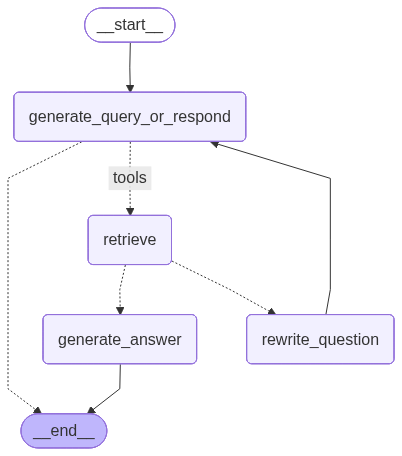

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is TPC-H database is used for?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

**TPC‑H** is a benchmark—not a production database—that models a **decision‑support (OLAP) workload**. It was created by the Transaction Processing Performance Council (TPC) to give a standardized, repeatable way to measure how well relational database systems handle complex, ad‑hoc queries on large volumes of data.

Below is a concise overview of what the TPC‑H database is used for, why it matters, and how it is typically employed.

---

## 1. Primary Purpose: Benchmarking Decision‑Support Systems  

| Goal | How TPC‑H achieves it |
|------|----------------------|
| **Measure query performance** | 22 standardized SQL queries (Q1‑Q22) that simulate real‑world analytical tasks (e.g., sales reporting, inventory analysis, market‑share calculations). |
| **Assess scalability** | Database sizes are defined in **scale factors** (SF 1 = 1 GB, SF 10 = 10 GB, … up to SF 1

In [24]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Who is TPC-H?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_docs (fc_458766fe-8c98-4578-b167-1ca0daf935b0)
 Call ID: fc_458766fe-8c98-4578-b167-1ca0daf935b0
  Args:
    query: TPC-H benchmark



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_docs

TPC BenchmarkTM H Standard Specification Revision 3.0.1 Page 8 
0:  INTRODUCTION 
0.1 Preamble 
The TPC Benchmark™H (TPC-H) is a decision support benchmark. It consists of a suite of business oriented ad -hoc 
queries and concurrent data modifications. The queries and the data populating the database have been chosen to 
have broad industry -wide relevance while maintaining a sufficient degree of ease of implementation. This 
benchmark illustrates decision support systems that 
• Examine large volumes of data; 
• Execute queries with a high degree of complexity; 
• Give answers to cr

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        print(update["messages"][-1])
        print("\n\n")